# CNN model (from "Fast Solar Image Classification Using Deep Learning and its Importance for Automation in Solar Physics" - Convolutional neural network)

## 0. Load modules


In [1]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Operating System Interaction
import os
import sys

# Machine Learning Frameworks
import torch
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader

# Data Transformation and Augmentation (not all of these transformations were finally used)
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, \
    RandomVerticalFlip, ColorJitter, RandomAffine, RandomPerspective, RandomResizedCrop, \
    GaussianBlur, RandomAutocontrast
from torchvision.transforms import functional as F

# Model Building and Initialization
import torch.nn as nn
from torch.nn.init import kaiming_normal_

# Data Loading and Dataset Handling
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, Subset
from PIL import Image

# Cross-Validation and Metrics
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, roc_curve, auc, accuracy_score
from scipy.special import expit as sigmoid

# Visualization and Display
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from IPython.display import HTML

# Miscellaneous
import random
from tqdm import tqdm

## 1. Import models

### 1.1 Declare data path

In [2]:
# For Google Colab, mount Google Drive, for local environments, get local path (github)

# Change with the appropriate path. Log in into Drive and create the folders with the data

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    folder0_path = '... your google path to .../data0'
    folder1_path = '... your google path to .../data1'
    folder0_test_path = '... your google path to .../data0_test'
    folder1_test_path = '... your google path to .../data1_test'
    folder0_valid_path = '... your google path to .../data0_val'
    folder1_valid_path = '... your google path to .../data1_val'


    # Carlos
    #folder0_path = '/content/drive/My Drive/solar_jets/data0'
    #folder0_test_path = '/content/drive/My Drive/solar_jets/data0_test'
    #folder1_path = '/content/drive/My Drive/solar_jets/data1'
    #folder1_test_path = '/content/drive/My Drive/solar_jets/data1_test'

    # Julie
    folder0_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data0'
    folder1_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1'
    folder0_test_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data0_test'
    folder1_test_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1_test'
    folder0_valid_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data0_val'
    folder1_valid_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1_val'

    #Adrien
    #folder0_path = '/content/drive/My Drive/Machine Learning/Projet/data0'
    #folder1_path = '/content/drive/My Drive/Machine Learning/Projet/data1'
    #folder0_test_path = '/content/drive/My Drive/Machine Learning/Projet/data0_test'
    #folder1_test_path = '/content/drive/My Drive/Machine Learning/Projet/data1_test'
    #folder0_valid_path = '/content/drive/My Drive/Machine Learning/Projet/data0_val'
    #folder1_valid_path = '/content/drive/My Drive/Machine Learning/Projet/data1_val'
else:
    # For local environments like VS Code
    folder0_path = '../data/data separated/data0'
    folder1_path = '../data/data separated/data1'
    folder0_test_path = '../data/data separated/data0_test'
    folder1_test_path = '../data/data separated/data1_test'
    folder0_valid_path = '../data/data separated/data0_val'
    folder1_valid_path = '../data/data separated/data1_val'

### 1.2 Declare the class and the transforms

In [3]:
class TensorTransforms:
    def __init__(self, rotate_angle=30):
        self.rotate_angle = rotate_angle

    def random_horizontal_flip(self, x):
        if random.random() > 0.5:
            return torch.flip(x, [2])  # Flip along width
        return x

    def random_vertical_flip(self, x):
        if random.random() > 0.5:
            return torch.flip(x, [1])  # Flip along height
        return x

    def random_rotation(self, x):
        # Random rotation in increments of 90 degrees for simplicity
        k = random.randint(0, 3)  # 0, 90, 180, or 270 degrees
        return torch.rot90(x, k, [1, 2])  # Rotate along height and width

    def __call__(self, x):
        x = self.random_horizontal_flip(x)
        x = self.random_vertical_flip(x)
        x = self.random_rotation(x)
        return x

class NPZDataset(Dataset):
    def __init__(self, data_dir, augment=True, mean=None, std=None):
        self.data_dir = data_dir
        self.augment = augment
        self.files = [f for f in os.listdir(data_dir) if self._check_file_shape(f)]
        self.transform = TensorTransforms()
        self.mean = mean
        self.std = std

    def _check_file_shape(self, file):
        file_path = os.path.join(self.data_dir, file)
        data = np.load(file_path)['arr_0']
        return data.shape == (166, 166, 30)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data = np.load(file_path)['arr_0']
        data = np.moveaxis(data, -1, 0)  # Move channel to first dimension

        data = torch.from_numpy(data).float()  # Convert to PyTorch tensor

        if self.augment: #way to improve is to add to the data
            data = self.transform(data) #there we should concatenate both data and data_transformed

        if self.mean is not None and self.std is not None:
            data = np.clip(data, a_min=None, a_max= 1000)
            data = (data - self.mean) / self.std


        label = 1.0 if 'data1' in self.data_dir else 0.0

        return data, np.float32(label)

In [4]:
mean_data = 50.564544677734375
std_data = 49.94772720336914

### 1.3 Get the data, declare the Dataloaders

In [5]:
train_data1 = NPZDataset(folder1_path, mean=mean_data, std=std_data, augment=True)
train_data0 = NPZDataset(folder0_path, mean=mean_data, std=std_data, augment=True)
train_dataset = torch.utils.data.ConcatDataset([train_data1, train_data0])

test_data1 = NPZDataset(folder1_test_path, mean=mean_data, std=std_data, augment=False)
test_data0 = NPZDataset(folder0_test_path, mean=mean_data, std=std_data, augment=False)
test_dataset = torch.utils.data.ConcatDataset([test_data1, test_data0])

valid_data1 = NPZDataset(folder1_valid_path, mean=mean_data, std=std_data, augment=False)
valid_data0 = NPZDataset(folder0_valid_path, mean=mean_data, std=std_data, augment=False)
validate_dataset = torch.utils.data.ConcatDataset([valid_data1, valid_data0])

In [6]:

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(validate_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

## 2. Define the RCNN, the predict and test functions

In [7]:
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.layer1 = nn.Sequential(
            nn.Conv2d(30,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        # hidden_size is an hyperparameter to be adjusted
        # try augmenting num_layers
        self.lstm = nn.LSTM(input_size=12800, hidden_size=256, num_layers=1, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128,32),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(32,1),
            #nn.Sigmoid()     # don't include it as it is already included in BCELogitLoss (BCELoss is less stable)
        )

        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.max_pool(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.max_pool(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.max_pool(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = self.layer8(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = out.view(out.size(0),-1)
        lstm_out, _ = self.lstm(out)
        out = self.classifier(lstm_out)

        return out

    def graph(self): #for visualization and debugging
        return nn.Sequential(self.layer1,self.layer2,self.maxPool,self.layer3,self.layer4,self.maxPool,self.layer5,self.layer6,self.maxPool,self.layer7,self.layer8, self.maxPool,self.layer8,self.layer8,self.maxPool,self.classifier)

In [8]:
def predict(model, train_loader, criterion, device, threshold):
    model.eval()
    correct, val_loss, total_length = 0, 0, 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in train_loader:

            #MOVING THE TENSORS TO THE CONFIGURED DEVICE
            data, target = data.to(device), target.to(device).unsqueeze(1).float()

            #FORWARD PASS
            output = model(data)
            loss = criterion(output, target)
            # PREDICTIONS
            pred = (torch.sigmoid(output) >= threshold).float()

            # PERFORMANCE CALCULATION
            val_loss += loss.item() * len(data)
            total_length += len(data)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.view(-1).cpu().numpy())
            all_targets.extend(target.view(-1).cpu().numpy())

    val_loss = val_loss / total_length
    val_acc = correct / total_length

    return val_loss, val_acc, np.array(all_preds), np.array(all_targets)


def test(model, train_loader, criterion, device, threshold):
    model.eval()
    correct, val_loss, total_length = 0, 0, 0
    all_preds = []
    all_targets = []
    all_out = []
    f1 = []

    with torch.no_grad():
        for data, target in train_loader:

            #MOVING THE TENSORS TO THE CONFIGURED DEVICE
            data, target = data.to(device), target.to(device).unsqueeze(1).float()

            #FORWARD PASS
            output = model(data)
            loss = criterion(output, target)
            # PREDICTIONS
            pred = (torch.sigmoid(output) >= threshold).float()

            # PERFORMANCE CALCULATION
            val_loss += loss.item() * len(data)
            total_length += len(data)
            correct += pred.eq(target.view_as(pred)).sum().item()

            all_preds.extend(pred.view(-1).cpu().numpy())
            all_targets.extend(target.view(-1).cpu().numpy())
            all_out.extend(output.view(-1).cpu().numpy())

    val_loss = val_loss / total_length
    val_acc = correct / total_length

    return val_loss, val_acc, np.array(all_preds), np.array(all_targets), np.array(all_out)

## 3. Import the trained models

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if 'google.colab' in sys.modules:
    from google.colab import drive
    #drive.mount('/content/drive')
    model_path = '... your google path to ... /Trained_RCNN.pth'
    model2_path = '... your google path to .../Trained_RCNN_2.pth'
else:
  model_path = './Trained_RCNN.pth'
  model2_path = './Trained_RCNN_2.pth'

model = torch.load(model_path, map_location=device)
model2 = torch.load(model2_path, map_location=device)

model.eval()
model2.eval()

model = model.to(device)
model2 = model2.to(device)

## 4. F1 score vs threshold for the 2 best models

In [ ]:
thresholds = np.linspace(0, 1, 100)
criterion = torch.nn.BCEWithLogitsLoss()
print(device)

""" Model 1 """

model_f1 = np.zeros(len(thresholds))
model_acc = np.zeros(len(thresholds))

for i,t in enumerate(thresholds):
    _, acc, pred, target, _ = test(model, valid_loader, criterion, device, t)
    f1 = f1_score(target, pred, average='binary')
    print(f"model 1, f1 = {f1}, acc = {acc} \n")
    model_f1[i] = f1
    model_acc[i] = acc



""" Model 2 """

model2_f1 = np.zeros(len(thresholds))
model2_acc = np.zeros(len(thresholds))

for i,t in enumerate(thresholds):
    _, acc, pred, target, _ = test(model2, valid_loader, criterion, device, t)
    f1 = f1_score(target, pred, average='binary')
    print(f"model 2, threshold:  {i}, f1 = {f1}, acc = {acc} \n")
    model2_f1[i] = f1
    model2_acc[i] = acc


cuda
model 1, f1 = 0.6666666666666666, acc = 0.5 

model 1, f1 = 0.8395904436860069, acc = 0.8134920634920635 

model 1, f1 = 0.8602150537634408, acc = 0.8452380952380952 

model 1, f1 = 0.8717948717948718, acc = 0.8611111111111112 

model 1, f1 = 0.8847583643122676, acc = 0.876984126984127 

model 1, f1 = 0.8838951310861424, acc = 0.876984126984127 

model 1, f1 = 0.887218045112782, acc = 0.8809523809523809 

model 1, f1 = 0.8905660377358492, acc = 0.8849206349206349 

model 1, f1 = 0.8939393939393939, acc = 0.8888888888888888 

model 1, f1 = 0.8897338403041825, acc = 0.8849206349206349 



KeyboardInterrupt: ignored

In [ ]:
best_idx1 = np.argmax(model_f1)
best_idx2 = np.argmax(model2_f1)

print(f"The higher F1-score of model 1 is {model_f1[best_idx1]} and corresponds to a threshold value of {thresholds[best_idx1]:.4}. \n ")
print(f"The higher F1-score of model 2 is {model2_f1[best_idx2]} and corresponds to a threshold value of {thresholds[best_idx2]:.4}. \n ")


The higher F1-score of model 1 is 0.8968253968253969 and corresponds to a threshold value of 0.2727. 
 
The higher F1-score of model 2 is 0.8634686346863469 and corresponds to a threshold value of 0.1616. 
 


### 4.1 Plot the results: F1 score and accuracy vs threshold for each model

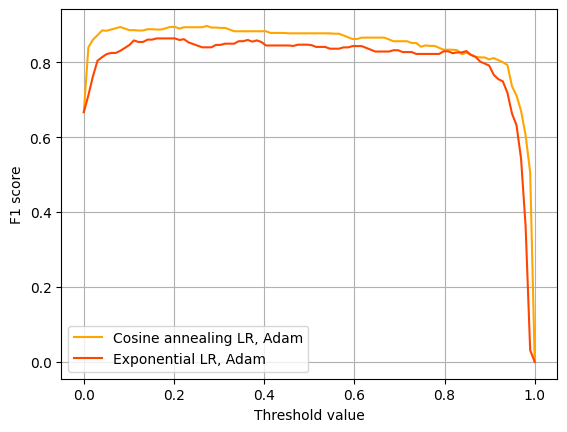

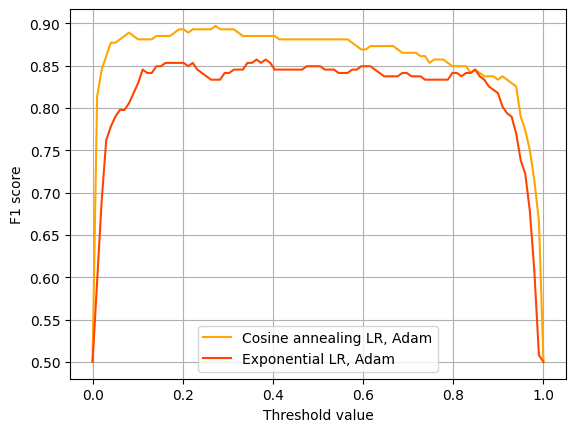

In [ ]:
""" F1 score """

fig, axs = plt.subplots()

axs.plot(thresholds, model_f1, color='orange', label='Cosine annealing LR, Adam')
axs.plot(thresholds, model2_f1, color='orangered', label='Exponential LR, Adam')

axs.set_xlabel('Threshold value')
axs.set_ylabel('F1 score')
axs.grid(True)
axs.legend()

fig.savefig('f1_vs_threshold.eps', format='eps')


""" Accuracy """

fig2, axs2 = plt.subplots()

axs2.plot(thresholds, model_acc, color='orange', label='Cosine annealing LR, Adam')
axs2.plot(thresholds, model2_acc, color='orangered', label='Exponential LR, Adam')

axs2.set_xlabel('Threshold value')
axs2.set_ylabel('F1 score')
axs2.grid(True)
axs2.legend()

## 5. Define, run and analyze best model (on test set now that this model is the final version!!)

In [10]:
# Define final model and threshold for further analysis
best_model = model
best_thres = 0.1
criterion = torch.nn.BCEWithLogitsLoss()

# Run the final model on test data and get the final F1 score
loss, accuracy, pred, target, _ = test(best_model, test_loader, criterion, device, best_thres)
test_f1 = f1_score(target, pred, average='binary')

In [11]:
print(f"Accuracy of the model on the test set: {accuracy:.4}")
print(f"Loss of the model on the test set: {loss:.4}")
print(f"F1 score on test set: {test_f1:.4}")

Accuracy of the model on the test set: 0.9231 

Loss of the model on the test set: 0.188 

F1 score on test set: 0.9286


## 5.1 Confusion matrix

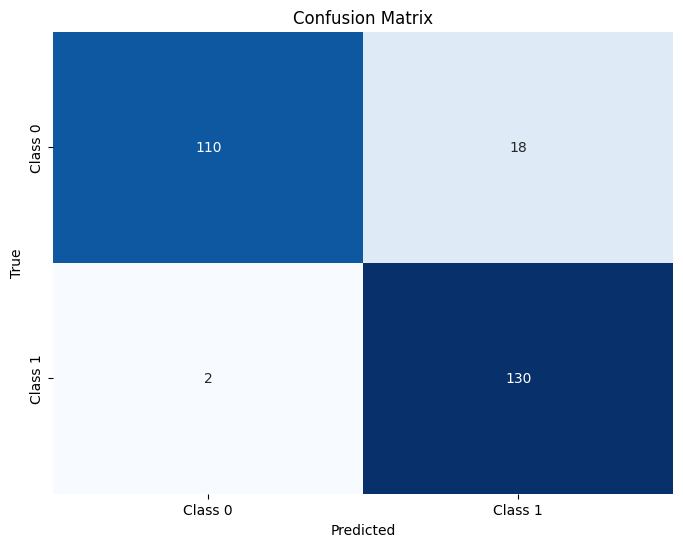

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(target, pred)

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


## 5.2 Misclassified images

In [13]:
#!pip install sunpy         # if running in colab, otherwise sunpy should be installed
import sunpy

from torchvision import transforms
import sunpy.visualization.colormaps as cm

In [15]:
# Set the model to evaluation mode
model = model.to(device)
threshold = 0.1

misclassified_images = []
true_labels = []
predicted_labels = []

count=0
itera=0
# Iterate through the test set
with torch.no_grad():
        for data, target in test_loader:
            itera+=1
            #MOVING THE TENSORS TO THE CONFIGURED DEVICE
            data, target = data.to(device), target.to(device).unsqueeze(1).float()

            #FORWARD PASS
            output = model(data)
            # PREDICTIONS
            pred = (torch.sigmoid(output) >= threshold).float().view(-1).cpu()
            target=target.view(-1).cpu()

            # Identify misclassified images
            misclassified_mask = pred != target
            count+=misclassified_mask.sum()


            misclassified_images.extend(data[misclassified_mask])
            true_labels.extend(target[misclassified_mask])
            predicted_labels.extend(pred[misclassified_mask])

print(f"There is {count} missclassified images")
# Convert lists to PyTorch tensors
misclassified_images = torch.stack(misclassified_images)
true_labels = torch.stack(true_labels)
predicted_labels = torch.stack(predicted_labels)

# Assuming you have a function to reverse normalization if applied during data preprocessing
# Replace reverse_normalize with your actual function
# Example:
reverse_normalize = transforms.Compose([transforms.Normalize(mean=0, std=(1/62.7087)),
                                        transforms.Normalize(mean=-51.6644, std=1)])



4
96
There is 20 missclassified images


### 5.2.2 Generate .gif animations of the 20 misclassified images

saving figure 1
saving figure 2
saving figure 3
saving figure 4
saving figure 5
saving figure 6
saving figure 7
saving figure 8
saving figure 9
saving figure 10
saving figure 11
saving figure 12
saving figure 13
saving figure 14
saving figure 15
saving figure 16
saving figure 17
saving figure 18
saving figure 19
saving figure 20


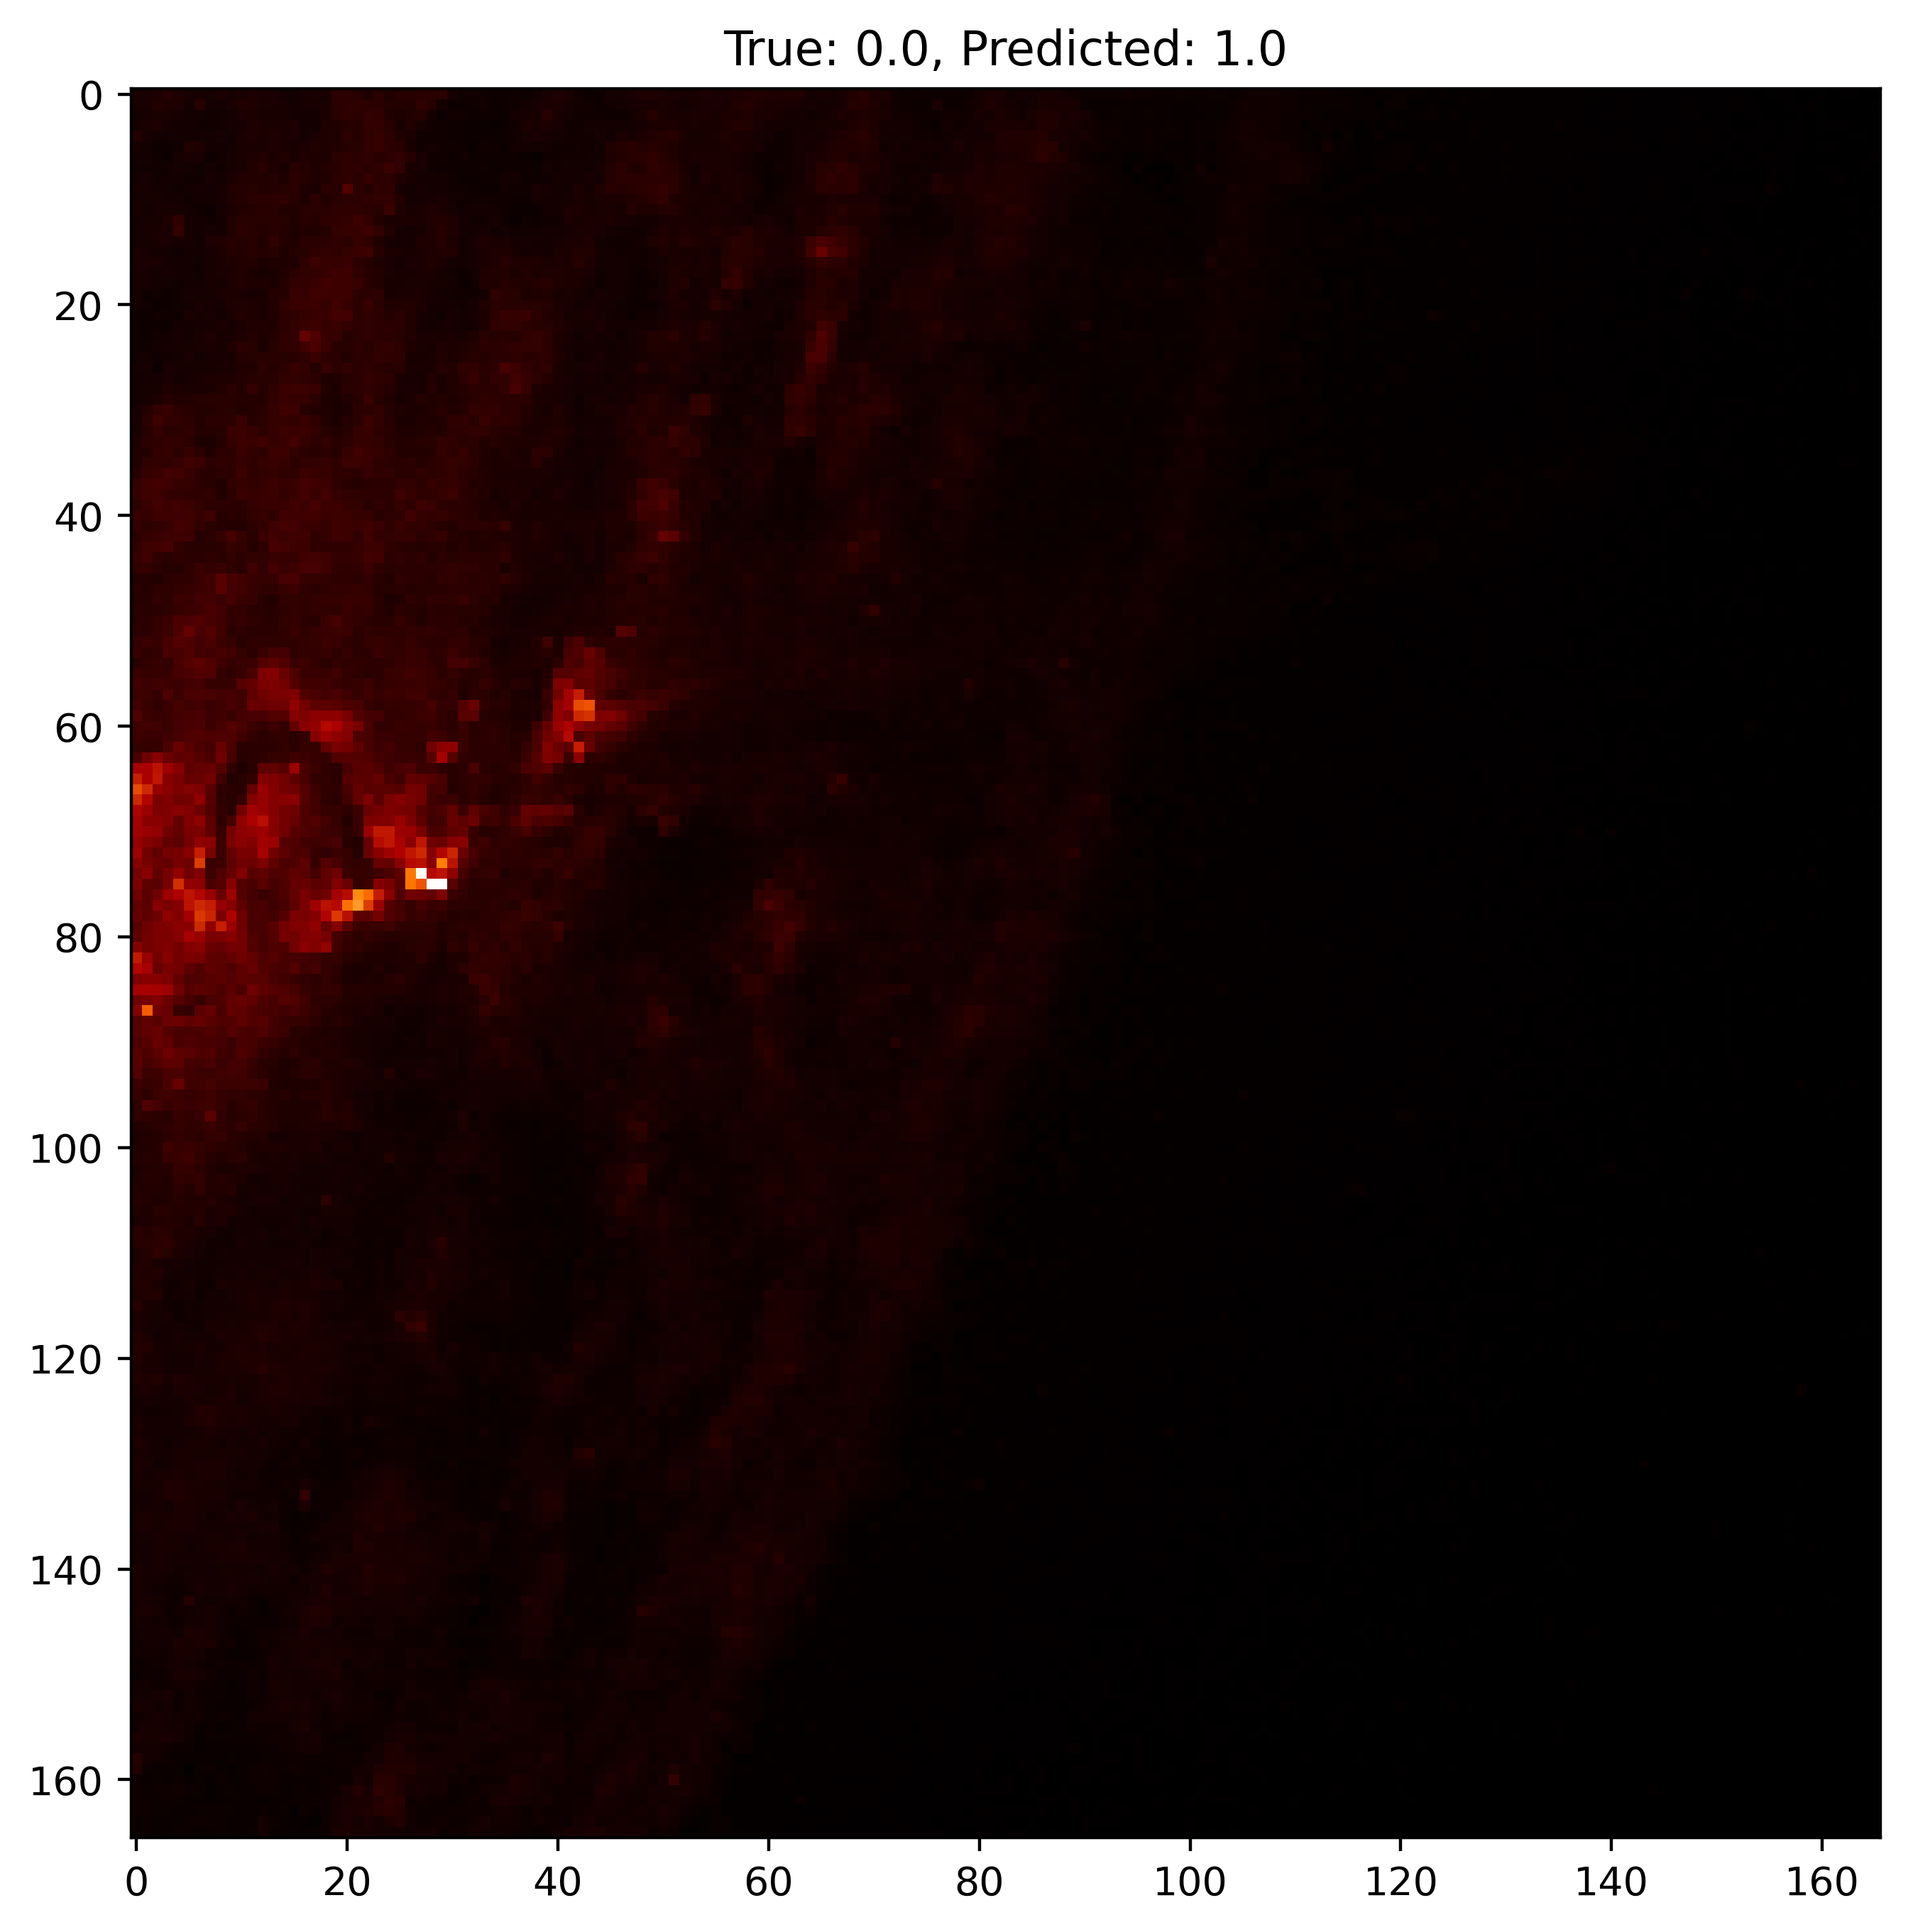

In [42]:
fig, ax = plt.subplots(dpi=400, figsize=(10, 8))

# Function to update the animation frame
def update(frame):
    im.set_array(image[frame, :, :])
    return im,

# loop over all misclassified images

for i in range(20):

    # Get the image sequence and the corresponding label and prediction
    image = misclassified_images[i].cpu().numpy()
    true_label = true_labels[i].item()
    predicted_label = predicted_labels[i].item()

    # Define the image normalization
    vmin, vmax = np.percentile(image, [1, 99.9])
    norm = Normalize(vmin=vmin, vmax=vmax)

    # Initialize the animation with an empty frame
    im = ax.imshow(image[0,: , :], cmap='sdoaia304', norm=norm)
    ax.set_title(f'True: {true_label}, Predicted: {predicted_label}')
    
    # Create the animation
    ani = FuncAnimation(fig, update, frames=30, interval=100, blit=True)  # 100 milliseconds per frame
    
    # Save in .gif format
    print(f"saving figure {i+1}")
    ani.save(f"figures/animation_{i+1}.gif", writer='pillow', fps=10, dpi=400)
    

## 5.3 ROC curve

In [ ]:
from sklearn.metrics import roc_curve, auc

loss, accuracy, pred, target, _ = test(best_model, test_loader, criterion, device, best_thres)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


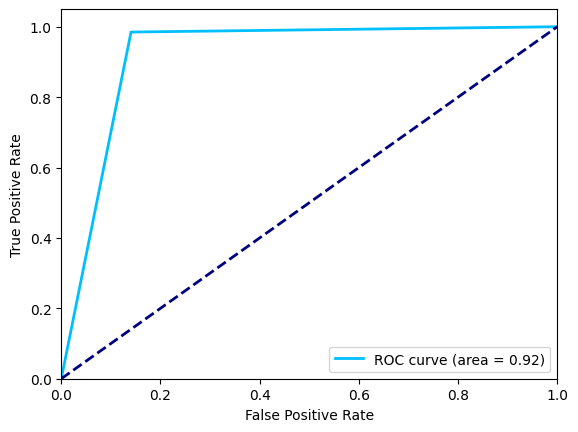

In [25]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(target, pred)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='deepskyblue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.savefig('figures/ROC.eps', format='eps')
plt.show()